<a href="https://colab.research.google.com/github/Bosy-Ayman/Basic-Search-Engine/blob/main/Search_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install the Pyterrier framework
!pip install python-terrier
# install the nltk modules
!pip install nltk

In [2]:
#install FLAIR
!pip install flair

In [3]:
#we need to install allennlp in order to be able to use elmo model
!pip install allennlp==0.9.0

  Using cached allennlp-0.9.0-py3-none-any.whl (7.6 MB)
  Using cached overrides-7.7.0-py3-none-any.whl (17 kB)
  Using cached spacy-2.1.9.tar.gz (30.7 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [4]:
import pyterrier as pt
if not pt.started():
  pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])


PyTerrier 0.10.1 has loaded Terrier 5.9 (built by craigm on 2024-05-02 17:40) and terrier-helper 0.0.8



In [5]:
#Import the necessary modules:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import *
from nltk.stem.porter import *
import pandas as pd
import re # used to clean the data
#to display the full text on the notebook without truncation
pd.set_option('display.max_colwidth', 150)

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Data** **collection**
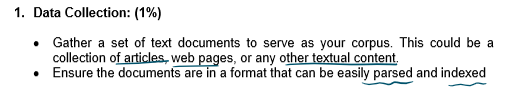

In [7]:
df = pd.read_csv('corona.csv')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,"TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #cor...",Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns...",Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and loved ones from #coronavirus. ?,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious shoppers stock up on food&amp;medical supplies after #healthcare worker in her 30s becomes #BigApple 1...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News #Corvid19 #7NewsMelb #dunnypapergate #Costco O...,Neutral


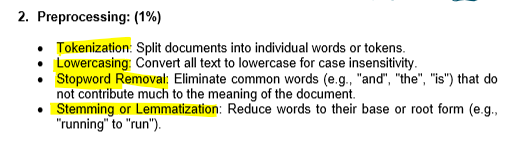

In [8]:
# Initialize Porter stemmer
stemmer = PorterStemmer()

In [9]:
def Stem_text(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    # print (tokens)
    return ' '.join(stemmed_tokens)

def clean(text):
   text = re.sub(r"[\.\,\#_\|\:\?\?\/\=\@]", " ", text) # remove special characters
   text = re.sub(r'\t', ' ', text) # remove tabs
   text = re.sub(r'\n', ' ', text) # remove line jump
   text = re.sub(r"\s+", " ", text) # remove extra white space
   text = text.strip()
   return text

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words] #Lower is used to normalize al the words make them in lower case
    # print('Tokens are:',tokens,'\n')
    return ' '.join(filtered_tokens)

#we need to process the query also as we did for documents
def preprocess(sentence):
  sentence = clean(sentence)
  sentence = remove_stopwords(sentence)
  sentence = Stem_text(sentence)
  return sentence

In [10]:
res = df['OriginalTweet'].apply(preprocess)
res

0       trend new yorker encount empti supermarket shelv ( pictur wegman brooklyn ) sold-out onlin grocer ( foodkick maxdeliveri ) coronavirus-fear shoppe...
1                          could n't find hand sanit fred meyer turn amazon $ 114 97 2 pack purel ! ! check coronaviru concern drive price http co ygbipbflmi
2                                                                                                                            find protect love one coronaviru
3       panic buy hit newyork citi anxiou shopper stock food & amp ; medic suppli healthcar worker 30 becom bigappl 1st confirm coronaviru patient bloombe...
4       toiletpap dunnypap coronaviru coronavirusaustralia coronavirusupd covid 19 9new corvid19 7newsmelb dunnypaperg costco one week everyon buy babi mi...
                                                                                ...                                                                          
3793                                                

# Indexing
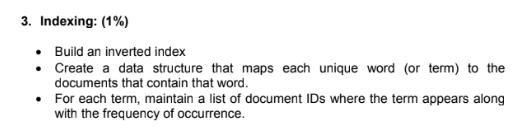

In [11]:
# Import the RM3 class from PyTerrier
from pyterrier.rewrite import RM3


In [ ]:
!git clone https://github.com/terrierteam/terrier-prf/
!apt-get install maven
%cd /content/terrier-prf/
!mvn install
!pwd
%cd ..

fatal: destination path 'terrier-prf' already exists and is not an empty directory.


In [ ]:
df['docno'] = df["ScreenName"].astype(str)
pd_indexer = pt.DFIndexer("./pd_index3")
indexref = pd_indexer.index(df["OriginalTweet"], df["docno"])

In [ ]:
index = pt.IndexFactory.of(indexref)

In [ ]:
word_to_documents = {}

inv = index.getInvertedIndex()
meta = index.getMetaIndex()

for kv in index.getLexicon():
    term = kv.getKey()
    pointer = index.getLexicon()[term]
    doc_ids = {}
    for posting in inv.getPostings(pointer):
        docno = meta.getItem("docno", posting.getId())
        if docno in doc_ids:
            doc_ids[docno] += 1
        else:
            doc_ids[docno] = 1

    word_to_documents[term] = doc_ids

for term, doc_freqs in word_to_documents.items():
    print("%s -> %s" % (term, doc_freqs))


# Query Processing
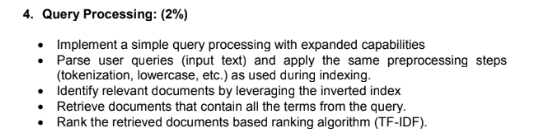

In [ ]:
retr = pt.BatchRetrieve(index, controls = {"wmodel": "TF_IDF"})

retr.setControl("wmodel", "TF_IDF")
retr.setControls({"wmodel": "TF_IDF"})

In [ ]:
query = "news"

In [ ]:
query_processed = preprocess(query)

In [ ]:
top_relevant = retr.search(query_processed)
top_relevant

In [ ]:
import pandas as pd
import pyterrier as pt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import os
pd.set_option('display.max_colwidth', 150)

# Query Expansion
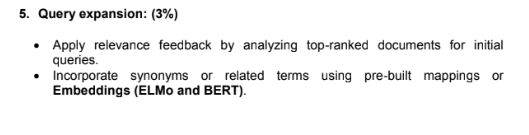

In [ ]:
# "rewrite" function from PyTerrier will be used to expand queries specifying RM3 as the model
# fb_docs ==> no. expansion documents
# fb_terms ==> no. expansion terms

rm3_expander = pt.rewrite.RM3(index,fb_terms=10, fb_docs=10)

rm3_qe = top_relevant >> rm3_expander
expanded_query = rm3_qe.search(query).iloc[0]["query"]

expanded_query

In [ ]:
# Just print the expanded query with term scores
for s in expanded_query.split()[1:]:
  print(s)

print("\n" + query)

# User interface
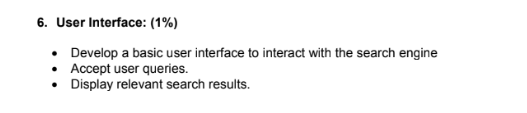

# Evaluation
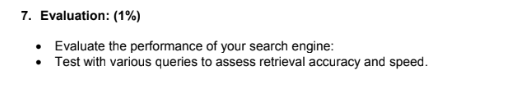

In [ ]:
vaswani_dataset = pt.datasets.get_dataset("vaswani")
topics = vaswani_dataset.get_topics()
topics.head(5)
qrels = vaswani_dataset.get_qrels()

In [ ]:
retr = pt.BatchRetrieve(index, controls = {"wmodel": "TF_IDF"})

retr.setControl("wmodel", "TF_IDF")
retr.setControls({"wmodel": "TF_IDF"})

res=retr.transform(topics)

In [ ]:
res

In [ ]:
retr.search("Light")


In [ ]:
eval = pt.Evaluate(res,qrels)
eval

In [ ]:
eval = pt.Evaluate(res,qrels,metrics=["map","recall","P"], perquery=True)
eval